## Data Augmentation with DeepFake-ECG

In [1]:
import numpy as np
import h5py
#import xml.etree.ElementTree as ET
import os
from torch_two_sample.statistics_diff import MMDStatistic
from HuggingProcess import ECGDataset
#from EcgPreprocessing import ECGDataset
import json
from transformers import AutoModel
from scipy.signal import resample, medfilt
import matplotlib.pyplot as plt
import Fred as fred
import torch
from IPython.display import display, HTML

from pulse2pulse import Pulse2pulseGenerator as Generator
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from frechetdist import frdist

ECG_REAL_NOFA_DIR = 'xml_data/data_gen/PFA'
ECG_REAL_FA_DIR = 'xml_data/data_gen/FA'

ECG_REAL_NOFA_TRACINGS = 'xml_data/data_gen/PFA/ecg_data_gen_nofa.h5'
ECG_REAL_FA_TRACINGS = 'xml_data/data_gen/FA/ecg_data_gen_fa.h5'

ECG_FAKE_NOFA_TRACINGS = 'xml_data/data_gen/Fake_Data/PFA/fake_ecg_nofa.h5'
ECG_FAKE_FA_TRACINGS = 'xml_data/data_gen/Fake_Data/FA/fake_ecg_fa.h5'

2023-06-21 16:33:22.962773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 16:33:23.403361: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 16:33:23.406142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 16:33:25.937528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# This code initializes a pre-trained AutoModel for deepfake ECG generation.
# The model is loaded from the "deepsynthbody/deepfake_ecg" repository on Hugging Face's model hub.
# trust_remote_code=True ensures that the remote code is trusted and can be executed safely.

model = AutoModel.from_pretrained("deepsynthbody/deepfake_ecg", trust_remote_code=True)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


In [3]:
# ecg_real_nofa = ECGDataset(input_dir=ECG_REAL_NOFA_DIR, output_file=ECG_REAL_NOFA_TRACINGS)
# ecg_real_nofa.xml_to_tensor()

In [4]:
# ecg_real_fa = ECGDataset(input_dir=ECG_REAL_FA_DIR, output_file=ECG_REAL_FA_TRACINGS)
# ecg_real_fa.xml_to_tensor()

In [5]:
# data = np.load("data.npy")

# derivations_to_keep = [0, 1, 6, 7, 8, 9, 10, 11]

# data_new = data[:, derivations_to_keep, :]

# print(data_new.shape) # (827, 8, 5000)

# This function reads an ECG file and extracts the pacemaker ECG data.
# Input: 
# - file_path: a string representing the path to the ECG file.
# Output:
# - ecg_real_nofa: a numpy array containing the pacemaker ECG data.

with h5py.File(ECG_REAL_NOFA_TRACINGS, 'r') as f:
        ecg_real_nofa = f['tracings'][:]
        
with h5py.File(ECG_REAL_FA_TRACINGS, 'r') as f:
        ecg_real_fa = f['tracings'][:]
        
print(ecg_real_nofa.shape)
print(ecg_real_fa.shape)

(34, 5000, 12)
(4, 5000, 12)


In [6]:
# Transpose ECG data from pacemaker

ecg_real_nofa_t = np.transpose(ecg_real_nofa, (0, 2,1))
ecg_real_fa_t = np.transpose(ecg_real_fa, (0, 2,1))

print(ecg_real_nofa_t.shape, ecg_real_fa_t.shape)

(34, 12, 5000) (4, 12, 5000)


In [7]:
derivations_to_keep = [0, 1, 6, 7, 8, 9, 10, 11]

ecg_real_nofa_t = ecg_real_nofa_t[:, derivations_to_keep, :]
ecg_real_fa_t = ecg_real_fa_t[:, derivations_to_keep, :]

print(ecg_real_nofa_t.shape)
print(ecg_real_fa_t.shape) # (827, 8, 5000)

(34, 8, 5000)
(4, 8, 5000)


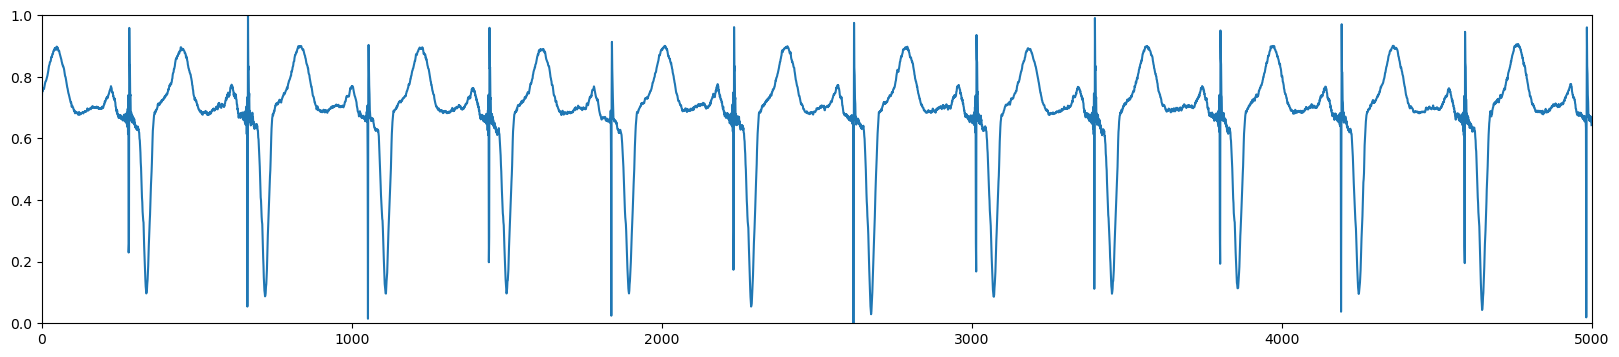

In [8]:
# This function plots an ECG signal
ecg_real_fa_sample = ecg_real_nofa_t[0, 1, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.set(xlim=(0, 5000), ylim=(0, 1))
ax.plot(ecg_real_fa_sample);


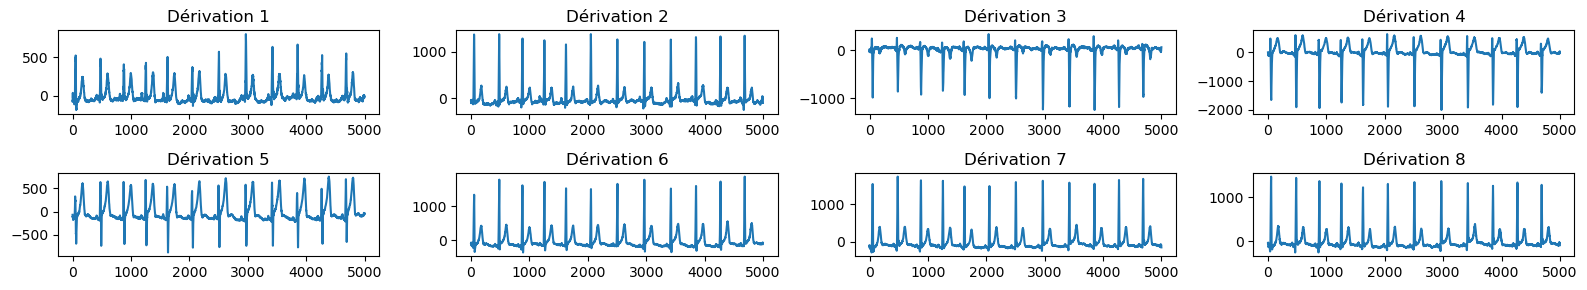

In [9]:
# This code generates a plot of the output of a model for 5 samples.
# The plot has 2 rows and 4 columns, with each subplot showing the output for one of the 8 derivations.
# The input parameter is num_samples, which specifies the number of samples to generate.
# The output parameter is a plot showing the output of the model for each derivation.

out = model(num_samples=5) # Generates output for 5 samples
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,3))

for i in range(2): # Loops through rows
    for j in range(4): # # Loops through columns
        ax[i,j].plot(out[0][:,j+(i*4)]) # Plots output for current derivation
        ax[i,j].set_title('Dérivation ' + str(j+(i*4)+1)) # Sets title for current subplot

plt.tight_layout()
plt.show()


In [10]:
# loads a pre-trained generator model and its statistics
# The generator model is used to generate synthetic data
# The function loads the model and sets it to evaluation mode

# We set the device to CPU
device = torch.device("cpu")

# We create an instance of the Generator class
netG = Generator()

# Load the pre-trained statistics of the generator model
model_gstat = torch.load('g_stat.pt', map_location=device)

#Load the state dictionary of the generator model from the loaded statistics
netG.load_state_dict(model_gstat["stat_dict"])

netG.to(device)
netG.eval()

/home/charlie/Documents/af_prediction_pipelines/pulse2pulse.py:85: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Pulse2pulseGenerator(
  (fc1): Linear(in_features=100, out_features=500, bias=True)
  (deconv_1): Transpose1dLayer(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(250, 250, kernel_size=(25,), stride=(1,))
    (Conv1dTrans): ConvTranspose1d(250, 250, kernel_size=(25,), stride=(1,), padding=(11,), output_padding=(1,))
  )
  (deconv_2): Transpose1dLayer_multi_input(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(500, 150, kernel_size=(25,), stride=(1,))
    (Conv1dTrans): ConvTranspose1d(500, 150, kernel_size=(25,), stride=(1,), padding=(11,), output_padding=(1,))
  )
  (deconv_3): Transpose1dLayer_multi_input(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(300, 50, kernel_size=(25,), str

In [11]:
## ECG_FAKE_NOFA_TRACINGS

# Creation a tensor from the first 34 values of the pkt_ecg array using PyTorch.
ecg_real_nofa_cond =torch.Tensor(ecg_real_nofa_t[:34]).uniform_(0, 1)

# Passes the tensor through a neural network called netG to generate synthetic data.
synth_ecg_real_nofa_cond = netG(ecg_real_nofa_cond)

#detaches the synthetic data from the computational graph and converts it to a numpy array.
out_ecg_fake_nofa_cond = synth_ecg_real_nofa_cond.detach().numpy()

print(out_ecg_fake_nofa_cond.shape)
print(ecg_real_nofa_t.shape)

(34, 8, 5000)
(34, 8, 5000)


In [12]:
## ECG_FAKE_FA_TRACINGS

# Creation a tensor from the first 34 values of the pkt_ecg array using PyTorch.
ecg_real_fa_cond =torch.Tensor(ecg_real_fa_t[:4]).uniform_(0, 1)

# Passes the tensor through a neural network called netG to generate synthetic data.
synth_ecg_real_fa_cond = netG(ecg_real_fa_cond)

#detaches the synthetic data from the computational graph and converts it to a numpy array.
out_ecg_fake_fa_cond = synth_ecg_real_fa_cond.detach().numpy()

print(out_ecg_fake_fa_cond.shape)
print(ecg_real_fa_t.shape)

(4, 8, 5000)
(4, 8, 5000)


In [13]:
def normalize_ecg_data(ecg_data):
    
    normalized_data = np.zeros_like(ecg_data, dtype=float)
    
    for i in range(ecg_data.shape[0]):
        for j in range(ecg_data.shape[1]):
            derivation = ecg_data[i, j, :]
            max_val = np.max(derivation)
            min_val = np.min(derivation)
            normalized_data[i, j, :] = (derivation - min_val) / (max_val - min_val)
    
    return normalized_data

In [14]:
ecg_fake_nofa_norm = normalize_ecg_data(out_ecg_fake_nofa_cond)
ecg_fake_fa_norm = normalize_ecg_data(out_ecg_fake_fa_cond)

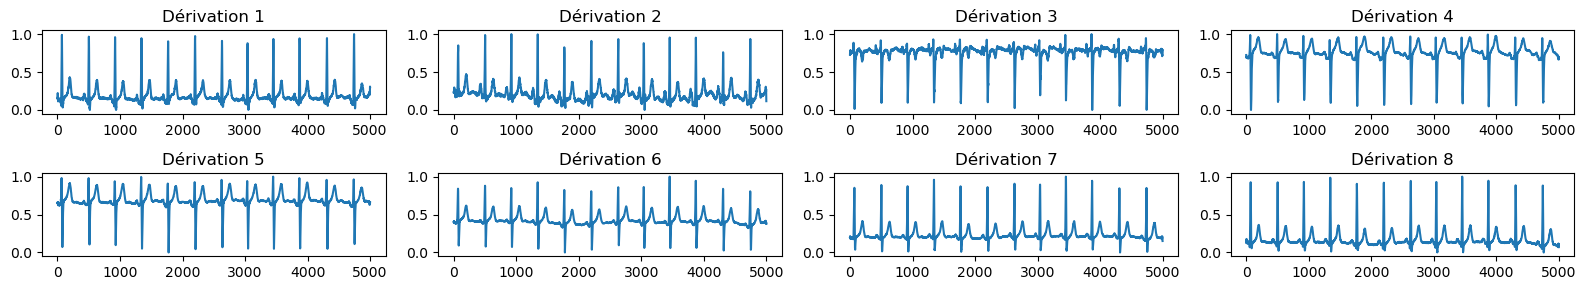

In [15]:
## FAKE NOFA
fig, axes = plt.subplots(2, 4, figsize=(16, 3))
for i in range(2):
    for j in range(4):
        derivation = i * 4 + j  
        ecg_fake_sample_nofa = ecg_fake_nofa_norm [0, derivation, :]
        
        axes[i, j].plot(ecg_fake_sample_nofa)
        axes[i, j].set_title(f"Dérivation {derivation + 1}")

plt.tight_layout()
plt.show()

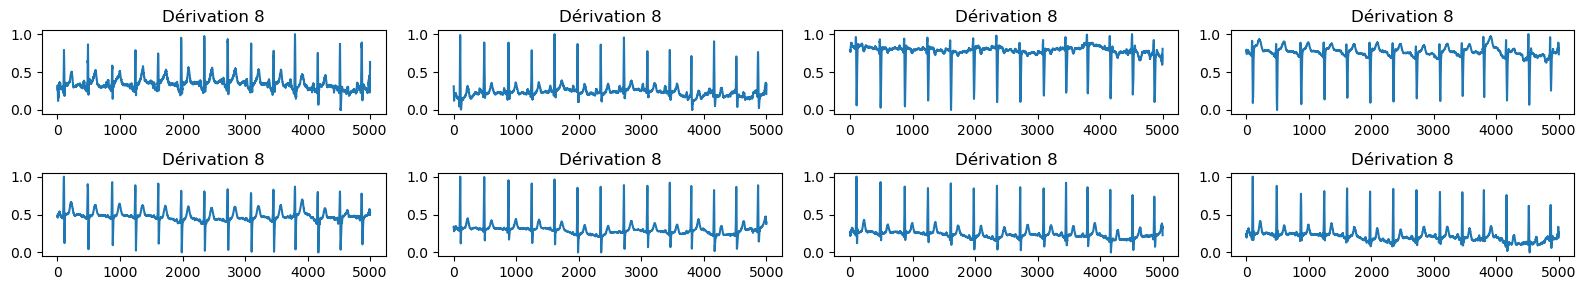

In [16]:
## FAKE FA
# Parcours des dérivations et affichage sur la grille
# Création de la grille de sous-graphiques

fig, axes = plt.subplots(2, 4, figsize=(16, 3))
for i in range(2):
    for j in range(4):
        d = i * 4 + j  # Numéro de la dérivation
        ecg_fake_sample_fa = ecg_fake_fa_norm [0, d, :]  # Premier ECG de la dérivation spécifique
        
        axes[i, j].plot(ecg_fake_sample_fa)
        axes[i, j].set_title(f"Dérivation {derivation + 1}")

# Réglages d'affichage des sous-graphiques
plt.tight_layout()
plt.show()

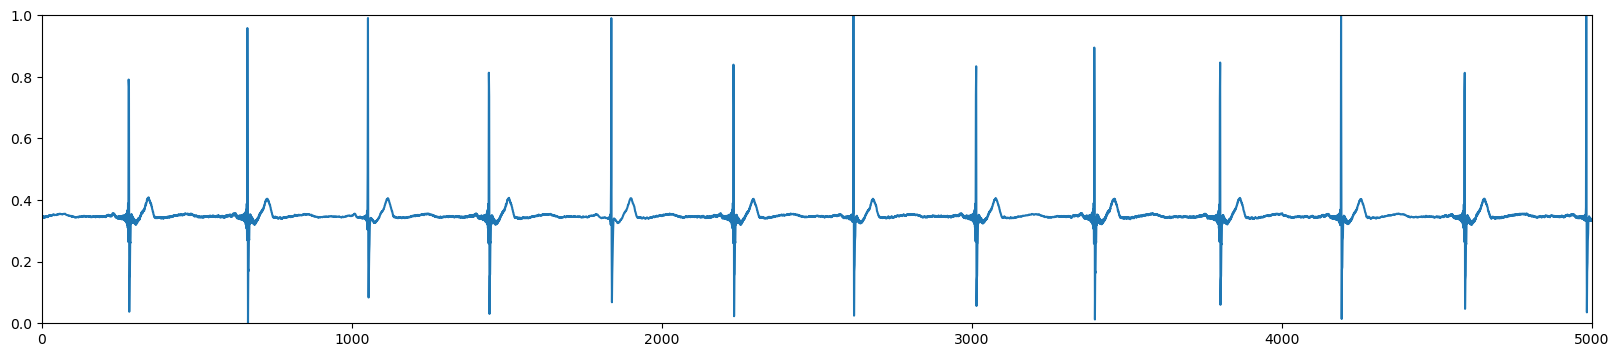

In [17]:
ecg = ecg_real_nofa_t[0, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.set(xlim=(0, 5000), ylim=(0, 1))
ax.plot(ecg);

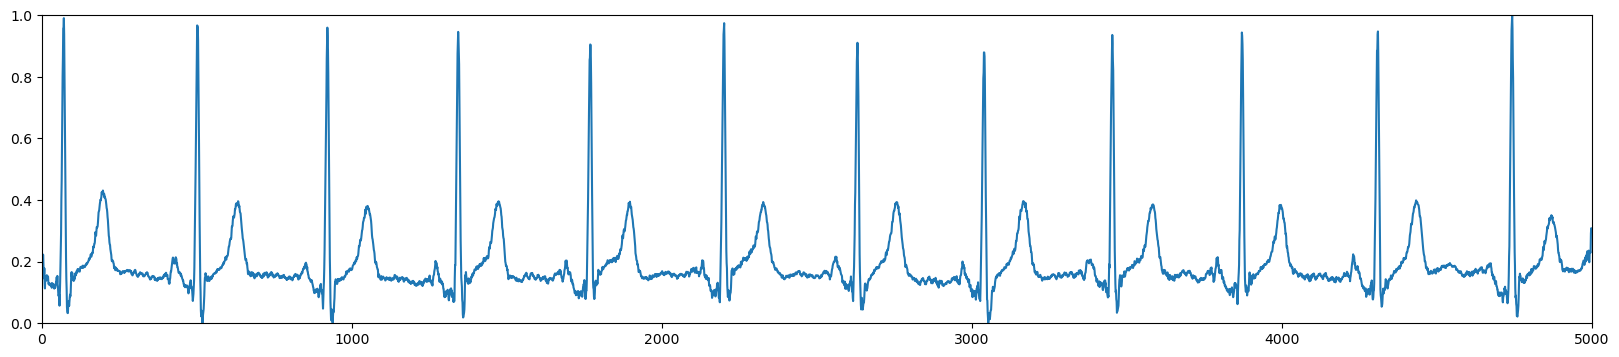

In [18]:
fake_ecg = ecg_fake_nofa_norm[0, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))
ax.set(xlim=(0, 5000), ylim=(0, 1))
ax.plot(fake_ecg);

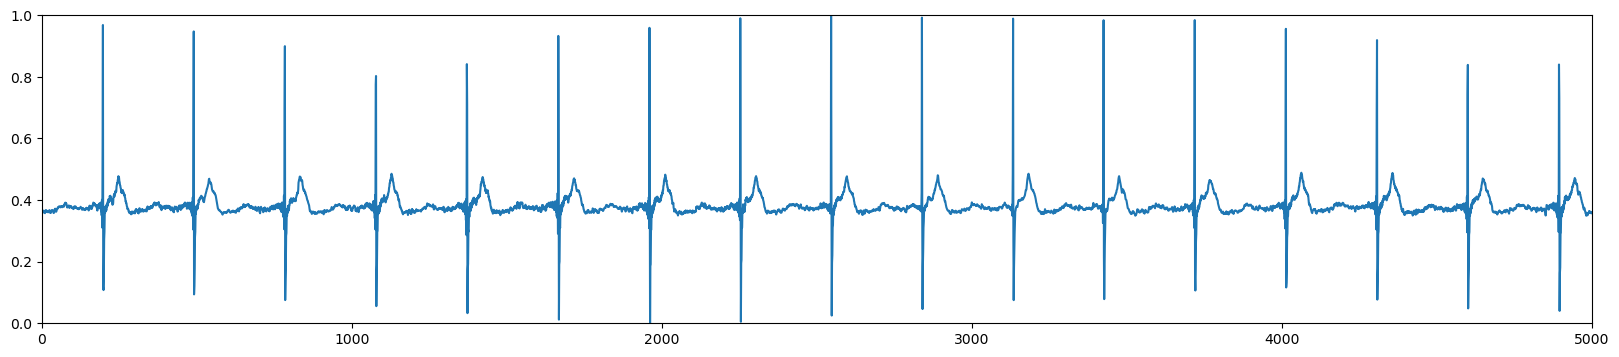

In [19]:
ecg_fa = ecg_real_fa_t[1, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.set(xlim=(0, 5000), ylim=(0, 1))
ax.plot(ecg_fa);

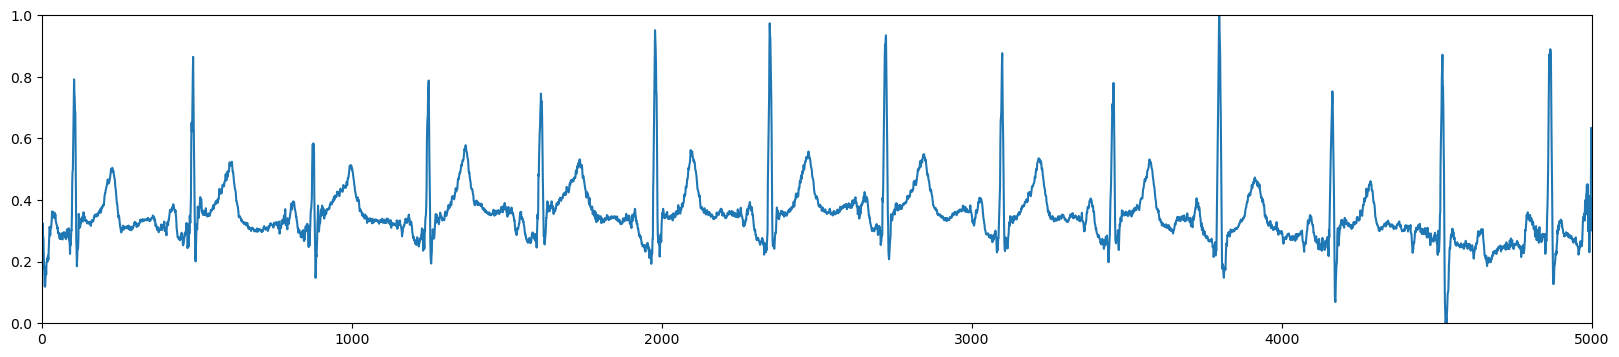

In [20]:
fake_ecg_fa = ecg_fake_fa_norm[0, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))
ax.set(xlim=(0, 5000), ylim=(0, 1))
ax.plot(fake_ecg_fa);

In [21]:
# def kernel_matrix(data):
#     n_samples = data.shape[0]
#     pairwise_dists = pairwise_distances(data.reshape(n_samples, -1))
#     sigma = np.median(pairwise_dists)
#     kernel = np.exp(-pairwise_dists**2 / (2 * sigma**2))
#     return kernel

# def mmd(K_real, K_synthetic):
#     n = K_real.shape[0]
#     m = K_synthetic.shape[0]
#     mmd = np.sum(K_real) / (n * (n - 1)) - 2 * np.sum(K_synthetic) / (n * m) + np.sum(K_synthetic) / (m * (m - 1))
#     return mmd

In [22]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def MMD_Kaggle(x, y, kernel):
#     """Emprical maximum mean discrepancy. The lower the result
#        the more evidence that distributions are the same.

#     Args:
#         x: first sample, distribution P
#         y: second sample, distribution Q
#         kernel: kernel type such as "multiscale" or "rbf"
#     """
#     xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
#     rx = (xx.diag().unsqueeze(0).expand_as(xx))
#     ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
#     dxx = rx.t() + rx - 2. * xx # Used for A in (1)
#     dyy = ry.t() + ry - 2. * yy # Used for B in (1)
#     dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
#     XX, YY, XY = (torch.zeros(xx.shape).to(device),
#                   torch.zeros(xx.shape).to(device),
#                   torch.zeros(xx.shape).to(device))
    
#     if kernel == "multiscale":
        
#         bandwidth_range = [0.2, 0.5, 0.9, 1.3]
#         for a in bandwidth_range:
#             XX += a**2 * (a**2 + dxx)**-1
#             YY += a**2 * (a**2 + dyy)**-1
#             XY += a**2 * (a**2 + dxy)**-1
            
#     if kernel == "rbf":
      
#         bandwidth_range = [10, 15, 20, 50]
#         for a in bandwidth_range:
#             XX += torch.exp(-0.5*dxx/a)
#             YY += torch.exp(-0.5*dyy/a)
#             XY += torch.exp(-0.5*dxy/a)
      
      

#     return torch.mean(XX + YY - 2. * XY)

In [23]:
# import torch

# def calculate_mmd_kaggle(data_orig, data_gen, kernel):
#     """
#     Calcule la Maximum Mean Discrepancy (MMD) entre les données originales et générées.

#     Args:
#         data_orig: données originales de forme (34, 12, 5000) / (4, 12, 5000)
#         data_gen: données générées de forme (34, 12, 5000) / (4, 12, 5000)
#         kernel: type de noyau ("multiscale" ou "rbf")

#     Returns:
#         mmd_score: score MMD entre les données originales et générées
#     """
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # Transformer les données en tenseurs PyTorch
#     x = torch.from_numpy(data_orig).to(device)
#     y = torch.from_numpy(data_gen).to(device)

#     # Permuter les dimensions pour avoir la forme (N, D, M)
#     x = x.permute(0, 2, 1)
#     y = y.permute(0, 2, 1)

#     # Réorganiser les dimensions pour avoir la forme (N*M, D)
#     x = x.reshape(-1, x.shape[-1])
#     y = y.reshape(-1, y.shape[-1])

#     # Calculer la MMD en utilisant la fonction MMD existante
#     mmd_score = MMD_Kaggle(x, y, kernel)

#     return mmd_score


In [24]:
def mmd(targets, predictions, samples):
    mmd_stat = MMDStatistic(5000, 5000)
    sample_target = torch.from_numpy(targets.reshape((samples*8, 5000)))
    sample_pred = torch.from_numpy(predictions.reshape((samples*8, 5000)))
    
    stat = mmd_stat(sample_target, sample_pred, [1.] * 5000)
    return stat.item()

In [25]:
# K_real = kernel_matrix(pkt_ecg)
# K_synthetic = kernel_matrix(fake_norm)
##### NOFA EVALUATION
mmd_nofa_value = mmd(ecg_real_nofa_t, ecg_fake_nofa_norm, samples=34)
print("Valeur du MMD entre les ECG générés du deep-fake et ceux qui sont réels:", mmd_nofa_value)

Valeur du MMD entre les ECG générés du deep-fake et ceux qui sont réels: 0.008404309930727329


In [26]:
# ##### NOFA EVALUATION
# mmd_nofa_value_kaggle = calculate_mmd_kaggle(ecg_real_nofa_t, ecg_fake_nofa_norm, kernel="rbf")
# print("Valeur du MMD entre les ECG générés du deep-fake et ceux qui sont réels:", mmd_nofa_value_kaggle)

In [27]:
# K_real = kernel_matrix(pkt_ecg)
# K_synthetic = kernel_matrix(fake_norm)
##### FA EVALUATION
mmd_fa_value = mmd(ecg_real_fa_t, ecg_fake_fa_norm, samples=4)
print("Valeur du MMD entre les ECG générés du deep-fake et ceux qui sont réels:", mmd_fa_value)

Valeur du MMD entre les ECG générés du deep-fake et ceux qui sont réels: 0.0004971252768902531


## Data Augmentation with ECG transformations

In [28]:
# The function below performs data augmentation on a given dataset.
# It takes in one input parameter:
# - data: a numpy array of shape (n_samples, n_features), where n_samples is the number 
# of samples and n_features is the number of features.

    # It returns one output parameter:
    # - augmented_data: a numpy array of shape (n_samples, n_features), where each sample 
    # in the original dataset has been randomly scaled up or down by a factor between 0.90 and 1.10.

def data_augmentation(data):
    # Create an empty list to store the augmented samples
    augmented_data = []
    
    # Get the number of samples in the dataset(52)
    n_samples = data.shape[0]
    
    ## Loop through each sample in the dataset
    for i in range(n_samples):
        
        # Get the current sample
        sample = data[i]
         # Make a copy of the current sample
        aug_sample = sample.copy()  
        # Generate random scaling factors for each feature
        delta = np.random.uniform(0.90, 1.00, size=(8, 5000)) 
        # Scale each feature by its corresponding scaling factor
        aug_sample *= delta  
        # Add the augmented sample to the list of augmented samples
        augmented_data.append(aug_sample)
        
    # Convert the list of augmented samples to a numpy array and return it
    augmented_data = np.array(augmented_data)
    return augmented_data

In [29]:
### NOFA
data_augmented_nofa = data_augmentation(ecg_real_nofa_t)
print(data_augmented_nofa.shape)

(34, 8, 5000)


In [30]:
###FA
data_augmented_fa = data_augmentation(ecg_real_fa_t)
print(data_augmented_fa.shape)

(4, 8, 5000)


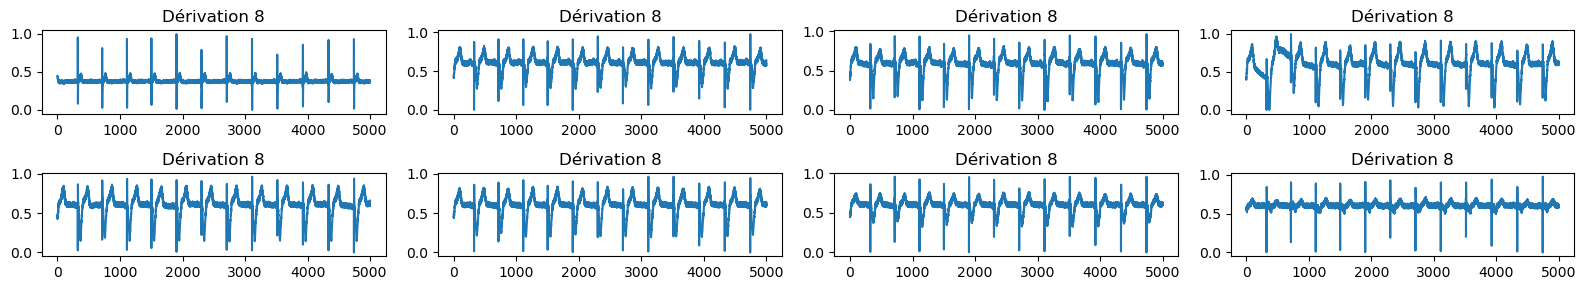

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(16, 3))
for i in range(2):
    for j in range(4):
        d = i * 4 + j  # Numéro de la dérivation
        ecg_real = data_augmented_nofa[5, d, :]  # Premier ECG de la dérivation spécifique
        
        axes[i, j].plot(ecg_real)
        axes[i, j].set_title(f"Dérivation {derivation + 1}")

# Réglages d'affichage des sous-graphiques
plt.tight_layout()
plt.show()

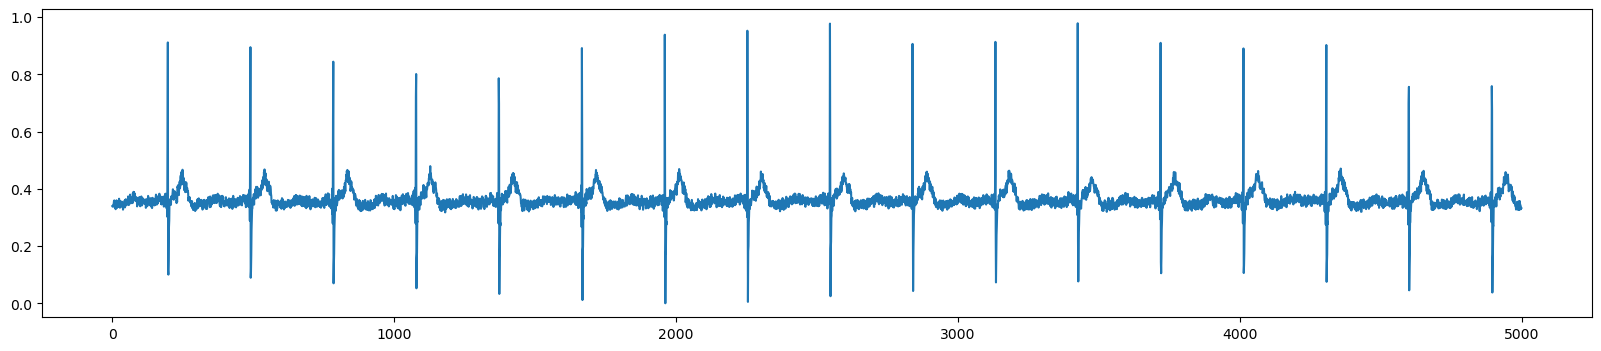

In [32]:
augmented_sample = data_augmented_fa[1, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(augmented_sample);

In [33]:
#K_augmented = kernel_matrix(data_augmented)
## NOFA
mmd_value_aug_nofa = mmd(ecg_real_nofa_t, data_augmented_nofa, samples=34)
print("Valeur du MMD entre les ECG générés de l'augmentation de données et ceux qui sont réels:", mmd_value_aug_nofa)

Valeur du MMD entre les ECG générés de l'augmentation de données et ceux qui sont réels: 0.010262944852025998


In [34]:
#K_augmented = kernel_matrix(data_augmented)
## FA
mmd_value_aug_fa = mmd(ecg_real_fa_t, data_augmented_fa, samples=4)
print("Valeur du MMD entre les ECG générés de l'augmentation de données et ceux qui sont réels:", mmd_value_aug_fa)

Valeur du MMD entre les ECG générés de l'augmentation de données et ceux qui sont réels: 0.0007717659270480899


In [35]:
#NOFA
df = pd.DataFrame({'Méthodes d\'augmentations sur les patients ne présentant pas de FA': ['DeepFake using GAN vs Real ECG Evaluation', 'Random Factors Multiplied vs Real ECG Evaluation'], 'Valeur MMD': [mmd_nofa_value, mmd_value_aug_nofa]})
print(df.to_string(index=False))

Méthodes d'augmentations sur les patients ne présentant pas de FA  Valeur MMD
                        DeepFake using GAN vs Real ECG Evaluation    0.008404
                 Random Factors Multiplied vs Real ECG Evaluation    0.010263


In [36]:
#FA
df = pd.DataFrame({'Méthodes d\'augmentations sur les patients ne présentant une FA': ['DeepFake using GAN vs Real ECG Evaluation', 'Random Factors Multiplied vs Real ECG Evaluation'], 'Valeur MMD': [mmd_fa_value, mmd_value_aug_fa]})
print(df.to_string(index=False))

Méthodes d'augmentations sur les patients ne présentant une FA  Valeur MMD
                     DeepFake using GAN vs Real ECG Evaluation    0.000497
              Random Factors Multiplied vs Real ECG Evaluation    0.000772


In [37]:
# def prd(targets, predictions):
#     # Reshape targets and predictions to (N, 4096) by flattening the 12 leads
#     targets_flat = np.reshape(targets, (targets.shape[0], -1))
#     predictions_flat = np.reshape(predictions, (predictions.shape[0], -1))

#     # Compute the sum of squared differences between targets and predictions
#     s1 = np.sum((targets_flat - predictions_flat)**2)

#     # Compute the sum of squared targets
#     s2 = np.sum(targets_flat**2)

#     # Compute the PRD
#     prd_value = np.sqrt(s1 / s2 * 100)

#     return prd_value

# def rmse(targets, predictions):
#     # Reshape targets and predictions to (N, 4096) by flattening the 12 leads
#     targets_flat = np.reshape(targets, (targets.shape[0], -1))
#     predictions_flat = np.reshape(predictions, (predictions.shape[0], -1))

#     # Compute the RMSE
#     rmse_value = np.sqrt(np.mean((targets_flat - predictions_flat)**2))

#     return rmse_value


In [38]:
# prd_nofa_value_deepfake = prd(ecg_real_nofa_t, ecg_fake_nofa_norm)
# rmse_nofa_value_deepfake = rmse(ecg_real_nofa_t, ecg_fake_nofa_norm)
# # fd_distance_nofa_deepfake = frdist(ecg_real_nofa_t, ecg_fake_nofa_norm)


# prd_fa_value_deepfake = prd(ecg_real_fa_t, ecg_fake_fa_norm)
# rmse_fa_value_deepfake = rmse(ecg_real_fa_t, ecg_fake_fa_norm)
# # fd_distance_fa_deepfake = frdist(ecg_real_fa_t, ecg_fake_fa_norm)


In [39]:
def mmd_edited(targets, predictions, samples):
    mmd_stat = MMDStatistic(5000, 5000)
    sample_target = torch.from_numpy(targets.reshape((samples*8, 5000)))
    sample_pred = torch.from_numpy(predictions.reshape((samples*8, 5000)))

    min_mmd = float('inf')  # Initialisation avec une valeur maximale
    max_mmd = float('-inf')  # Initialisation avec une valeur minimale
    total_mmd = 0
    sample_count = 0

    for _ in range(samples):
        stat = mmd_stat(sample_target, sample_pred, [1.] * 5000)
        mmd_value = stat.item()
        min_mmd = min(min_mmd, mmd_value)
        max_mmd = max(max_mmd, mmd_value)
        total_mmd += mmd_value
        sample_count += 1

    average_mmd = total_mmd / sample_count

    return min_mmd, max_mmd, average_mmd



In [40]:

def prd_edited(targets, predictions):
    # Reshape targets and predictions to (N, 4096) by flattening the 12 leads
    targets_flat = np.reshape(targets, (targets.shape[0], -1))
    predictions_flat = np.reshape(predictions, (predictions.shape[0], -1))

    prd_values = []

    for i in range(targets_flat.shape[0]):
        # Compute the sum of squared differences between targets and predictions
        s1 = np.sum((targets_flat[i] - predictions_flat[i])**2)

        # Compute the sum of squared targets
        s2 = np.sum(targets_flat[i]**2)

        # Compute the PRD
        prd_value = np.sqrt(s1 / s2 * 100)
        prd_values.append(prd_value)

    min_prd = np.min(prd_values)
    max_prd = np.max(prd_values)
    avg_prd = np.mean(prd_values)

    return min_prd, max_prd, avg_prd


def rmse_edited(targets, predictions):
    # Reshape targets and predictions to (N, 4096) by flattening the 12 leads
    targets_flat = np.reshape(targets, (targets.shape[0], -1))
    predictions_flat = np.reshape(predictions, (predictions.shape[0], -1))

    rmse_values = []

    for i in range(targets_flat.shape[0]):
        # Compute the RMSE
        rmse_value = np.sqrt(np.mean((targets_flat[i] - predictions_flat[i])**2))
        rmse_values.append(rmse_value)

    min_rmse = np.min(rmse_values)
    max_rmse = np.max(rmse_values)
    avg_rmse = np.mean(rmse_values)

    return min_rmse, max_rmse, avg_rmse

In [41]:
# print("Pas de FA")
# print(mmd_nofa_value, prd_nofa_value_deepfake, rmse_nofa_value_deepfake)

In [42]:
# print("FA")
# print(mmd_fa_value, prd_fa_value_deepfake, rmse_fa_value_deepfake)

## Évaluation de la génération synthétique à partir du DeepFake

### Métriques d'évaluation des ECG générés pour les patients n'ayant pas eu de FA

In [43]:
curves1_nofa = fred.Curves()
curves2_nofa = fred.Curves()


for ecg_data in ecg_real_nofa_t:
    curve = fred.Curve(ecg_data)
    curves1_nofa.add(curve)
    
for ecg_data in ecg_fake_nofa_norm:
    curve = fred.Curve(ecg_data)
    curves2_nofa.add(curve)

In [44]:
# print("distance is {}".format(fred.continuous_frechet(curves1_nofa[0], curves2_nofa[1]).value))

In [45]:
min_distance_fd = float('inf')  # Initialisation avec une valeur maximale
max_distance_fd = float('-inf')  # Initialisation avec une valeur minimale
total_distance = 0
pair_count = 0

for curve1 in curves1_nofa:
    for curve2 in curves2_nofa:
        result = fred.continuous_frechet(curve1, curve2)
        distance = result.value
        min_distance_fd = min(min_distance_fd, distance)
        max_distance_fd = max(max_distance_fd, distance)
        total_distance += distance
        pair_count += 1

average_distance_fd = total_distance / pair_count



# print("Minimum distance:", min_distance_fd)
# print("Maximum distance:", max_distance_fd)
# print("Average distance:", average_distance_fd)

In [46]:
# NOFA
min_mmd_nofa, max_mmd_nofa, avg_mmd_nofa = mmd_edited(ecg_real_nofa_t, ecg_fake_nofa_norm, samples=34)

# print("Minimum MMD:", min_mmd_nofa)
# print("Maximum MMD:", max_mmd_nofa)
# print("Average MMD:", avg_mmd_nofa)

In [47]:
min_prd_nofa, max_prd_nofa, avg_prd_nofa = prd_edited(ecg_real_nofa_t, ecg_fake_nofa_norm)
min_rmse_nofa, max_rmse_nofa, avg_rmse_nofa = rmse_edited(ecg_real_nofa_t, ecg_fake_nofa_norm)

# print("Minimum PRD:", min_prd_nofa)
# print("Maximum PRD:", max_prd_nofa)
# print("Average PRD:", avg_prd_nofa)
# print("=====================================")
# print("Minimum RMSE:", min_rmse_nofa)
# print("Maximum RMSE:", max_rmse_nofa)
# print("Average RMSE:", avg_rmse_nofa)

In [71]:
# Création du DataFrame
data_nofa = {
    'Metric': ['Minimum', 'Maximum', 'Average'],
    'FD Distance': [min_distance_fd, max_distance_fd, average_distance_fd],
    'MMD': [min_mmd_nofa, max_mmd_nofa, avg_mmd_nofa],
    'PRD': [min_prd_nofa, max_prd_nofa, avg_prd_nofa],
    'RMSE': [min_rmse_nofa, max_rmse_nofa, avg_rmse_nofa]
}

df_nofa = pd.DataFrame(data_nofa)

styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': '', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]},
    {'selector': '.dataframe', 'props': [('border-collapse', 'collapse'), ('border', '2px solid black')]}
]

styled_df_nofa = df_nofa.style.set_table_styles(styles).hide_index()

# Affichage du DataFrame
display(HTML(styled_df_nofa.render()))

/tmp/ipykernel_179631/3269323679.py:23: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  styled_df_nofa = df_nofa.style.set_table_styles(styles).hide_index()
/tmp/ipykernel_179631/3269323679.py:26: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(styled_df_nofa.render()))


Metric,FD Distance,MMD,PRD,RMSE
Minimum,16.186815,0.008404,3.326128,0.213729
Maximum,44.345508,0.008404,6.413831,0.423495
Average,31.198721,0.008404,5.219651,0.327545


### Métriques d'évaluation des ECG générés pour les patients ayant eu une FA

In [49]:
curves1_fa = fred.Curves()
curves2_fa = fred.Curves()


for ecg_data in ecg_real_fa_t:
    curve = fred.Curve(ecg_data)
    curves1_fa.add(curve)
    
for ecg_data in ecg_fake_fa_norm:
    curve = fred.Curve(ecg_data)
    curves2_fa.add(curve)
    
min_distance_fd_fa = float('inf')  # Initialisation avec une valeur maximale
max_distance_fd_fa = float('-inf')  # Initialisation avec une valeur minimale
total_distance = 0
pair_count = 0

for curve1 in curves1_fa:
    for curve2 in curves2_fa:
        result = fred.continuous_frechet(curve1, curve2)
        distance = result.value
        min_distance_fd_fa = min(min_distance_fd_fa, distance)
        max_distance_fd_fa = max(max_distance_fd_fa, distance)
        total_distance += distance
        pair_count += 1

average_distance_fd_fa = total_distance / pair_count


min_mmd_fa, max_mmd_fa, avg_mmd_fa = mmd_edited(ecg_real_fa_t, ecg_fake_fa_norm, samples=4)
min_prd_fa, max_prd_fa, avg_prd_fa = prd_edited(ecg_real_fa_t, ecg_fake_fa_norm)
min_rmse_fa, max_rmse_fa, avg_rmse_fa = rmse_edited(ecg_real_fa_t, ecg_fake_fa_norm)



In [72]:
data_fa = {
    'Metric': ['Minimum', 'Maximum', 'Average'],
    'FD Distance': [min_distance_fd_fa, max_distance_fd_fa, average_distance_fd_fa],
    'MMD': [min_mmd_fa, max_mmd_fa, avg_mmd_fa],
    'PRD': [min_prd_fa, max_prd_fa, avg_prd_fa],
    'RMSE': [min_rmse_fa, max_rmse_fa, avg_rmse_fa]
}

df_fa = pd.DataFrame(data_fa)

styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': '', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]},
    {'selector': '.dataframe', 'props': [('border-collapse', 'collapse'), ('border', '2px solid black')]}
]

styled_df_fa = df_fa.style.set_table_styles(styles).hide_index()

# Affichage du DataFrame
display(HTML(styled_df_fa.render()))

/tmp/ipykernel_179631/849458801.py:22: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  styled_df_fa = df_fa.style.set_table_styles(styles).hide_index()
/tmp/ipykernel_179631/849458801.py:25: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(styled_df_fa.render()))


Metric,FD Distance,MMD,PRD,RMSE
Minimum,23.683650,0.000497,4.363925,0.242529
Maximum,40.096648,0.000497,6.111107,0.374435
Average,31.645739,0.000497,5.341234,0.317430


## Évaluation de la génération synthétique à partir de l'augmentation de données servant de base de référence

### Métriques d'évaluation des ECG générés pour les patients n'ayant pas eu de FA

In [51]:
curves1_nofa_aug = fred.Curves()
curves2_nofa_aug = fred.Curves()

# ecg_real_nofa_t, data_augmented_nofa

for ecg_data in ecg_real_nofa_t:
    curve = fred.Curve(ecg_data)
    curves1_nofa_aug.add(curve)
    
for ecg_data in data_augmented_nofa:
    curve = fred.Curve(ecg_data)
    curves2_nofa_aug.add(curve)
    
min_distance_fd_nofa_aug = float('inf')  # Initialisation avec une valeur maximale
max_distance_fd_nofa_aug = float('-inf')  # Initialisation avec une valeur minimale
total_distance = 0
pair_count = 0

for curve1 in curves1_nofa_aug:
    for curve2 in curves2_nofa_aug:
        result = fred.continuous_frechet(curve1, curve2)
        distance = result.value
        min_distance_fd_nofa_aug = min(min_distance_fd_nofa_aug, distance)
        max_distance_fd_nofa_aug = max(max_distance_fd_nofa_aug, distance)
        total_distance += distance
        pair_count += 1

average_distance_fd_nofa_aug = total_distance / pair_count


min_mmd_nofa_aug, max_mmd_nofa_aug, avg_mmd_nofa_aug = mmd_edited(ecg_real_nofa_t, data_augmented_nofa, samples=34)
min_prd_nofa_aug, max_prd_nofa_aug, avg_prd_nofa_aug = prd_edited(ecg_real_nofa_t, data_augmented_nofa)
min_rmse_nofa_aug, max_rmse_nofa_aug, avg_rmse_nofa_aug = rmse_edited(ecg_real_nofa_t, data_augmented_nofa)



In [52]:
# Création du DataFrame
data_nofa_aug = {
    'Metric': ['Minimum', 'Maximum', 'Average'],
    'FD Distance': [min_distance_fd_nofa_aug, max_distance_fd_nofa_aug, average_distance_fd_nofa_aug],
    'MMD': [min_mmd_nofa_aug, max_mmd_nofa_aug, avg_mmd_nofa_aug],
    'PRD': [min_prd_nofa_aug, max_prd_nofa_aug, avg_prd_nofa_aug],
    'RMSE': [min_rmse_nofa_aug, max_rmse_nofa_aug, avg_rmse_nofa_aug]
}

df_nofa_aug = pd.DataFrame(data_nofa_aug)

styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': '', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]},
    {'selector': '.dataframe', 'props': [('border-collapse', 'collapse'), ('border', '2px solid black')]}
]

styled_df_nofa = df_nofa_aug.style.set_table_styles(styles).hide_index()

# Affichage du DataFrame
display(HTML(styled_df_nofa.render()))

/tmp/ipykernel_179631/3926899692.py:23: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  styled_df_nofa = df_nofa_aug.style.set_table_styles(styles).hide_index()
/tmp/ipykernel_179631/3926899692.py:26: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(styled_df_nofa.render()))


Metric,FD Distance,MMD,PRD,RMSE
Minimum,2.455968,0.010263,0.573362,0.031429
Maximum,31.985936,0.010263,0.580554,0.039524
Average,14.931727,0.010263,0.577110,0.036312


### Métriques d'évaluation des ECG générés pour les patients ayant eu une FA

In [53]:
curves1_fa_aug = fred.Curves()
curves2_fa_aug = fred.Curves()

# ecg_real_fa_t, data_augmented_fa

for ecg_data in ecg_real_fa_t:
    curve = fred.Curve(ecg_data)
    curves1_fa_aug.add(curve)
    
for ecg_data in data_augmented_fa:
    curve = fred.Curve(ecg_data)
    curves2_fa_aug.add(curve)
    
min_distance_fd_fa_aug = float('inf')  # Initialisation avec une valeur maximale
max_distance_fd_fa_aug = float('-inf')  # Initialisation avec une valeur minimale
total_distance = 0
pair_count = 0

for curve1 in curves1_fa_aug:
    for curve2 in curves2_fa_aug:
        result = fred.continuous_frechet(curve1, curve2)
        distance = result.value
        min_distance_fd_fa_aug = min(min_distance_fd_fa_aug, distance)
        max_distance_fd_fa_aug = max(max_distance_fd_fa_aug, distance)
        total_distance += distance
        pair_count += 1

average_distance_fd_fa_aug = total_distance / pair_count


min_mmd_fa_aug, max_mmd_fa_aug, avg_mmd_fa_aug = mmd_edited(ecg_real_fa_t, data_augmented_fa, samples=4)
min_prd_fa_aug, max_prd_fa_aug, avg_prd_fa_aug = prd_edited(ecg_real_fa_t, data_augmented_fa)
min_rmse_fa_aug, max_rmse_fa_aug, avg_rmse_fa_aug = rmse_edited(ecg_real_fa_t, data_augmented_fa)



In [54]:
# Création du DataFrame
data_fa_aug = {
    'Metric': ['Minimum', 'Maximum', 'Average'],
    'FD Distance': [min_distance_fd_fa_aug, max_distance_fd_fa_aug, average_distance_fd_fa_aug],
    'MMD': [min_mmd_fa_aug, max_mmd_fa_aug, avg_mmd_fa_aug],
    'PRD': [min_prd_fa_aug, max_prd_fa_aug, avg_prd_fa_aug],
    'RMSE': [min_rmse_fa_aug, max_rmse_fa_aug, avg_rmse_fa_aug]
}

df_fa_aug = pd.DataFrame(data_fa_aug)

styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': '', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]},
    {'selector': '.dataframe', 'props': [('border-collapse', 'collapse'), ('border', '2px solid black')]}
]

styled_df_fa = df_fa_aug.style.set_table_styles(styles).hide_index()

# Affichage du DataFrame
display(HTML(styled_df_fa.render()))

/tmp/ipykernel_179631/3252028211.py:23: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  styled_df_fa = df_fa_aug.style.set_table_styles(styles).hide_index()
/tmp/ipykernel_179631/3252028211.py:26: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(styled_df_fa.render()))


Metric,FD Distance,MMD,PRD,RMSE
Minimum,2.528001,0.000772,0.575742,0.032139
Maximum,18.528602,0.000772,0.578621,0.037307
Average,11.672196,0.000772,0.577760,0.034184


### Évaluation des données réelles à partir d'une base de donnée validée par la littérature (Telehealth Network of Minas Gerais in the period between 2010 and 2016) servant de base de référence globale afin d'évaluer les valuers des différentes métriques

In [55]:
def resample_data(data, new_length):
    n_samples, n_channels, n_points = data.shape
    
    # Créer un tableau vide pour stocker les données rééchantillonnées
    resampled_data = np.zeros((n_samples, n_channels, new_length))
    
    # Rééchantillonner chaque échantillon et chaque canal individuellement
    for i in range(n_samples):
        for j in range(n_channels):
            resampled_data[i, j, :] = resample(data[i, j, :], new_length)
    
    return resampled_data

In [56]:
# # Chemin vers les fichiers CSV et HDF5
# csv_file = 'xml_data/test_data/exams.csv'
# hdf5_file = 'xml_data/test_data/exams_part9.hdf5'

# # Charger le fichier CSV dans un DataFrame pandas
# df = pd.read_csv(csv_file)

# # Filtrer les lignes où 'normal_ecg' est True
# df_filtered = df[df['normal_ecg'] == True]
 
# # Récupérer les exam_ids correspondants
# exam_ids = df_filtered['exam_id'].values

# # Ouvrir le fichier HDF5
# h5_file = h5py.File(hdf5_file, 'r')

# # Récupérer les tracings correspondants aux exam_ids filtrés
# tracings = h5_file['tracings']
# filtered_tracings = tracings[np.isin(h5_file['exam_id'], exam_ids)]

# # Fermer le fichier HDF5
# h5_file.close()

# # Créer un nouveau fichier HDF5 pour enregistrer les tracés filtrés
# output_hdf5_file = 'xml_data/test_data/filtered.h5'
# output_h5_file = h5py.File(output_hdf5_file, 'w')

# # Créer un groupe dans le fichier HDF5 pour stocker les tracés
# output_h5_file.create_group('tracings')

# # Enregistrer les tracés filtrés dans le groupe 'tracings'
# output_h5_file['normal'] = filtered_tracings

# # Fermer le fichier HDF5
# output_h5_file.close()

In [57]:
with h5py.File('xml_data/test_data/filtered.h5', 'r') as f:
        brazil_data = f['normal'][:100]
        

brazil_data_t = np.transpose(brazil_data, (0,2,1))
brazil_data_t = brazil_data_t[:, derivations_to_keep, :]
print(brazil_data_t.shape)

print("====================")


brazil_resampled = normalize_ecg_data(resample_data(brazil_data_t, 5000))

print(brazil_resampled.shape)

(100, 8, 4096)
(100, 8, 5000)


In [58]:
new_brazil_torch =torch.Tensor(brazil_resampled).uniform_(0, 1)

# Passes the tensor through a neural network called netG to generate synthetic data.
synth_new_brazil = netG(new_brazil_torch)

#detaches the synthetic data from the computational graph and converts it to a numpy array.
out_new_brazil = synth_new_brazil.detach().numpy()

print(out_new_brazil.shape)

(100, 8, 5000)


In [59]:
out_new_brazil = normalize_ecg_data(out_new_brazil)
print(out_new_brazil.shape)

(100, 8, 5000)


In [61]:
curves1_brazil = fred.Curves()
curves2_brazil = fred.Curves()

for ecg_data in brazil_resampled:
    curve = fred.Curve(ecg_data)
    curves1_brazil.add(curve)
    
for ecg_data in out_new_brazil:
    curve = fred.Curve(ecg_data)
    curves2_brazil.add(curve)
    
min_distance_fd_brazil = float('inf')  # Initialisation avec une valeur maximale
max_distance_fd_brazil = float('-inf')  # Initialisation avec une valeur minimale
total_distance = 0
pair_count = 0

for curve1 in curves1_brazil:
    for curve2 in curves2_brazil:
        result = fred.continuous_frechet(curve1, curve2)
        distance = result.value
        min_distance_fd_brazil = min(min_distance_fd_brazil, distance)
        max_distance_fd_brazil = max(max_distance_fd_brazil, distance)
        total_distance += distance
        pair_count += 1

average_distance_fd_brazil = total_distance / pair_count


In [67]:
min_mmd_brazil, max_mmd_brazil, avg_mmd_brazil = mmd_edited(brazil_resampled[:50],out_new_brazil[:50], samples=50)


In [62]:
min_prd_brazil, max_prd_brazil, avg_prd_brazil = prd_edited(brazil_resampled,out_new_brazil)

In [63]:
min_rmse_brazil, max_rmse_brazil, avg_rmse_brazil = rmse_edited(brazil_resampled,out_new_brazil)

In [78]:
# Création du DataFrame
data_brazil = {
    'Metric': ['Minimum', 'Maximum', 'Average'],
    'FD Distance': [min_distance_fd_brazil, max_distance_fd_brazil, average_distance_fd_brazil],
    'MMD': [min_mmd_brazil, max_mmd_brazil, avg_mmd_brazil],
    'PRD': [min_prd_brazil, max_prd_brazil, avg_prd_brazil],
    'RMSE': [min_rmse_brazil, max_rmse_brazil, avg_rmse_brazil],
}

df_brazil = pd.DataFrame(data_brazil)

styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': '', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]},
    {'selector': '.dataframe', 'props': [('border-collapse', 'collapse'), ('border', '2px solid black')]}
]

styled_df_brazil = df_brazil.style.set_table_styles(styles).hide_index()

# Affichage du DataFrame
display(HTML(styled_df_brazil.render()))
display(HTML(styled_df_nofa.render()))

/tmp/ipykernel_179631/416693561.py:23: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  styled_df_brazil = df_brazil.style.set_table_styles(styles).hide_index()
/tmp/ipykernel_179631/416693561.py:26: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(styled_df_brazil.render()))


Metric,FD Distance,MMD,PRD,RMSE
Minimum,9.691733,0.002095,3.138585,0.147917
Maximum,45.517521,0.002095,9.611742,0.383262
Average,17.660565,0.002095,4.907572,0.234540


/tmp/ipykernel_179631/416693561.py:27: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(styled_df_nofa.render()))


Metric,FD Distance,MMD,PRD,RMSE
Minimum,16.186815,0.008404,3.326128,0.213729
Maximum,44.345508,0.008404,6.413831,0.423495
Average,31.198721,0.008404,5.219651,0.327545


In [79]:
curves1_brazil = fred.Curves()
curves2_brazil = fred.Curves()

for ecg_data in brazil_resampled[:4]:
    curve = fred.Curve(ecg_data)
    curves1_brazil.add(curve)
    
for ecg_data in out_new_brazil[:4]:
    curve = fred.Curve(ecg_data)
    curves2_brazil.add(curve)
    
min_distance_fd_brazil_simfa = float('inf')  # Initialisation avec une valeur maximale
max_distance_fd_brazil_simfa = float('-inf')  # Initialisation avec une valeur minimale
total_distance = 0
pair_count = 0

for curve1 in curves1_brazil:
    for curve2 in curves2_brazil:
        result = fred.continuous_frechet(curve1, curve2)
        distance = result.value
        min_distance_fd_brazil_simfa = min(min_distance_fd_brazil_simfa, distance)
        max_distance_fd_brazil_simfa = max(max_distance_fd_brazil_simfa, distance)
        total_distance += distance
        pair_count += 1

average_distance_fd_brazil_simfa = total_distance / pair_count

min_mmd_brazil_simfa, max_mmd_brazil_simfa, avg_mmd_brazil_simfa = mmd_edited(brazil_resampled[:4],out_new_brazil[:4], samples=4)
min_prd_brazil_simfa, max_prd_brazil_simfa, avg_prd_brazil_simfa = prd_edited(brazil_resampled[:4],out_new_brazil[:4])
min_rmse_brazil_simfa, max_rmse_brazil_simfa, avg_rmse_brazil_simfa = rmse_edited(brazil_resampled[:4],out_new_brazil[:4])

# Création du DataFrame
data_brazil = {
    'Metric': ['Minimum', 'Maximum', 'Average'],
    'FD Distance': [min_distance_fd_brazil_simfa, max_distance_fd_brazil_simfa, average_distance_fd_brazil_simfa],
    'MMD': [min_mmd_brazil_simfa, max_mmd_brazil_simfa, avg_mmd_brazil_simfa],
    'PRD': [min_prd_brazil_simfa, max_prd_brazil_simfa, avg_prd_brazil_simfa],
    'RMSE': [min_rmse_brazil_simfa, max_rmse_brazil_simfa, avg_rmse_brazil_simfa],
}

df_brazil_simfa = pd.DataFrame(data_brazil)

styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': '', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]},
    {'selector': '.dataframe', 'props': [('border-collapse', 'collapse'), ('border', '2px solid black')]}
]

styled_df_brazil_simfa = df_brazil_simfa.style.set_table_styles(styles).hide_index()

# Affichage du DataFrame
display(HTML(styled_df_brazil_simfa.render()))
display(HTML(styled_df_fa.render()))

/tmp/ipykernel_179631/1618606081.py:54: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  styled_df_brazil_simfa = df_brazil_simfa.style.set_table_styles(styles).hide_index()
/tmp/ipykernel_179631/1618606081.py:57: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(styled_df_brazil_simfa.render()))


Metric,FD Distance,MMD,PRD,RMSE
Minimum,12.927161,0.000047,4.466201,0.209278
Maximum,23.218601,0.000047,6.649059,0.272214
Average,15.973965,0.000047,5.591049,0.244310


/tmp/ipykernel_179631/1618606081.py:58: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(styled_df_fa.render()))


Metric,FD Distance,MMD,PRD,RMSE
Minimum,23.683650,0.000497,4.363925,0.242529
Maximum,40.096648,0.000497,6.111107,0.374435
Average,31.645739,0.000497,5.341234,0.317430


## Calcul des autres dérivations manquantes : 
- **lead III value** = (lead II value) - (lead I value)
- **lead aVR value** = -0.5*(lead I value + lead II value)
- **lead aVL value** = lead I value - 0.5 * lead II value
- **lead aVF value** = lead II value - 0.5 * lead I value


In [80]:
# ["lead_1", "lead_2", "lead_3", "lead_avr", "lead_avl", "lead_avf","lead_v1", "lead_v2", "lead_v3", "lead_v4", "lead_v5", "lead_v6"]

def retrieve_derivations(data_preprocessed):
    n_samples, n_existing_derivations, n_points = data_preprocessed.shape
    n_new_derivations = 4  # Nombre de nouvelles dérivations à retrouver
    
    # Créez un tableau vide pour stocker les nouvelles dérivations
    data_full = np.zeros((n_samples, n_existing_derivations + n_new_derivations, n_points))
    
    # Copiez les dérivations existantes dans le nouvel ensemble de données
    data_full[:, :n_existing_derivations, :] = data_preprocessed
    
    # Retrouvez les nouvelles dérivations en utilisant les formules fournies
    data_full[:, n_existing_derivations, :] = data_full[:, 1, :] - data_full[:, 0, :]  # lead_3
    data_full[:, n_existing_derivations + 1, :] = -0.5 * (data_full[:, 0, :] + data_full[:, 1, :])  # lead_avr
    data_full[:, n_existing_derivations + 2, :] = data_full[:, 0, :] - 0.5 * data_full[:, 1, :]  # lead_avl
    data_full[:, n_existing_derivations + 3, :] = data_full[:, 1, :] - 0.5 * data_full[:, 0, :]  # lead_avf
    
    # Réorganisez les dérivations pour correspondre à l'ordre souhaité
    order = ["lead_1", "lead_2", "lead_3", "lead_avr", "lead_avl", "lead_avf", "lead_v1", "lead_v2", "lead_v3", "lead_v4", "lead_v5", "lead_v6"]
    data_full_reordered = np.zeros((n_samples, n_existing_derivations + n_new_derivations, n_points))
    for i, deriv_name in enumerate(order):
        deriv_index = order.index(deriv_name)
        data_full_reordered[:, i, :] = data_full[:, deriv_index, :]
    
    return data_full_reordered

## Générer une quantité d'ECG suivant une classe

In [81]:
def generate(dataset, output_file, num_of_sample, start_id=0):
    
    generated_samples = np.zeros((num_of_sample, 8, 5000))

    for i in tqdm(range(start_id, start_id + num_of_sample)):
        noise = torch.Tensor(dataset[:1]).uniform_(0, 1)
        noise = noise.to(device)
        out = netG(noise)
        # out_rescaled = out * 6000
        # out_rescaled = out_rescaled.int()
        # out_rescaled_t = torch.t(out_rescaled.squeeze())
        generated_samples[i - start_id] = out.detach().cpu().numpy()

    with h5py.File(output_file, "w") as file:
        file.create_dataset("samples", data=generated_samples)


In [84]:
# Pour les patients n'ayant pas de présenté de FA
generate(ecg_real_nofa_t, 'xml_data/data_gen/Fake_Data/PFA/fake_ecg_nofa.h5', num_of_sample=100)

100%|██████████| 100/100 [00:02<00:00, 49.11it/s]


In [85]:
# Pour les patients ayant présenté une  FA
generate(ecg_real_fa_t, 'xml_data/data_gen/Fake_Data/FA/fake_ecg_fa.h5', num_of_sample=100)

100%|██████████| 100/100 [00:01<00:00, 50.82it/s]


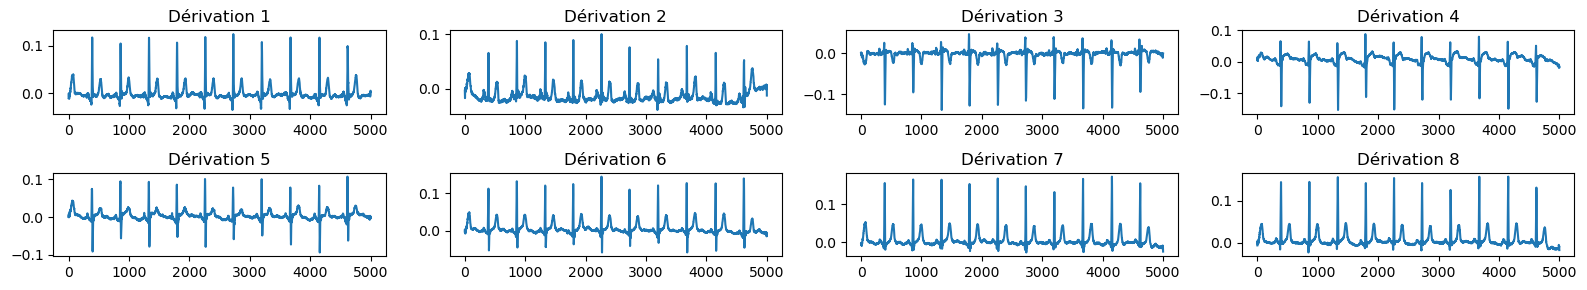

In [86]:

# This function plots an ECG signal
with h5py.File('xml_data/data_gen/Fake_Data/PFA/fake_ecg_nofa.h5', 'r') as f:
        test_nofa = f['samples'][:]
        
#print(test_fa.shape)      
# test_fa_sample = test_fa[1, 0, :]
# fig, ax = plt.subplots(figsize=(20, 4))

# ax.set(xlim=(0, 5000), ylim=(0, 1))
# ax.plot(test_fa_sample);


fig, axes = plt.subplots(2, 4, figsize=(16, 3))
for i in range(2):
    for j in range(4):
        derivation = i * 4 + j  
        test_fa_sample = test_nofa[0, derivation, :]
        
        axes[i, j].plot(test_fa_sample)
        axes[i, j].set_title(f"Dérivation {derivation + 1}")

plt.tight_layout()
plt.show()


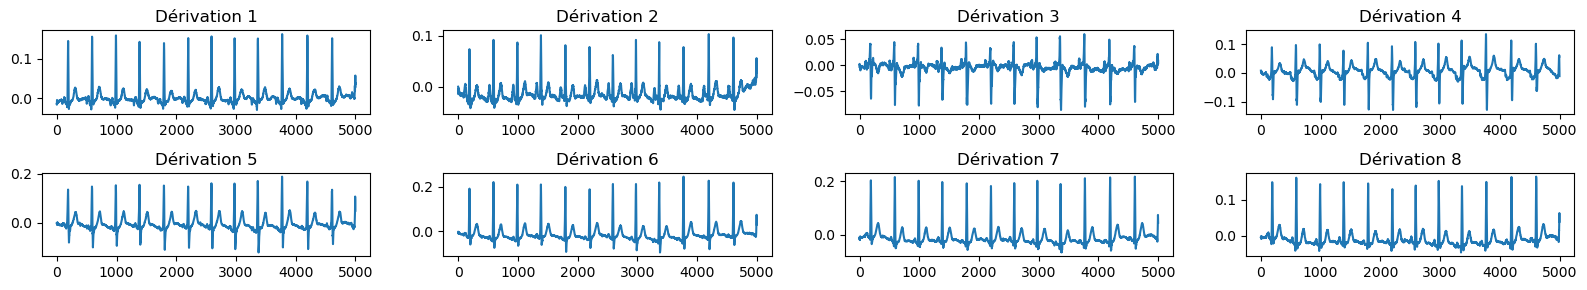

In [87]:

# This function plots an ECG signal
with h5py.File('xml_data/data_gen/Fake_Data/FA/fake_ecg_fa.h5', 'r') as f:
        test_fa = f['samples'][:]
        
#print(test_fa.shape)      
# test_fa_sample = test_fa[1, 0, :]
# fig, ax = plt.subplots(figsize=(20, 4))

# ax.set(xlim=(0, 5000), ylim=(0, 1))
# ax.plot(test_fa_sample);


fig, axes = plt.subplots(2, 4, figsize=(16, 3))
for i in range(2):
    for j in range(4):
        derivation = i * 4 + j  
        test_fa_sample = test_fa[0, derivation, :]
        
        axes[i, j].plot(test_fa_sample)
        axes[i, j].set_title(f"Dérivation {derivation + 1}")

plt.tight_layout()
plt.show()


In [89]:
test_nofa = resample_data(test_nofa, 4096)
test_fa = resample_data(test_fa, 4096)

test_nofa_norm = normalize_ecg_data(test_nofa)
test_fa_norm = normalize_ecg_data(test_fa)

#NOFA
fakes_recover_nofa = retrieve_derivations(test_nofa_norm)
#FA
fakes_recover_fa = retrieve_derivations(test_fa_norm)

print(fakes_recover_nofa.shape, fakes_recover_fa.shape)

(100, 12, 4096) (100, 12, 4096)


In [90]:

noX = np.transpose(fakes_recover_nofa, (0,2,1))
faX = np.transpose(fakes_recover_fa, (0,2,1))


with h5py.File('xml_data/data_gen/Fake_Data/PFA/finals_fakes_nofa.h5', 'w') as f:
            f.create_dataset('tracings', data=noX)
            
with h5py.File('xml_data/data_gen/Fake_Data/FA/finals_fakes_fa.h5', 'w') as f:
            f.create_dataset('tracings', data=faX)
            